In [1]:
import numpy as np
import os
import random
import torch
from configs.configs import Configs
from models.predictor_model import EssayScorer
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import remove_top_p_sample, fit_func, pred_func, calc_qwk, random_remove_sample, discover_corrupted_sample
from sklearn.metrics import mean_squared_error

/Users/takumishibata/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ↓y_trainにノイズを乗せる処理を加える必要がある

load data from data/train_dev_test_split/7/fold-0/...
Loading embedding from cache...
X_train:  (942, 1024)
Y_train:  (942,)
Y_train max:  0.8
Y_train min:  0.06666666666666667
X_dev:  (314, 1024)
Y_dev:  (314,)
Y_dev max:  0.8
Y_dev min:  0.13333333333333333
X_test:  (313, 1024)
Y_test:  (313,)
Y_test max:  0.8
Y_test min:  0.13333333333333333
Creating predictor model...
QWK: 0.7120
Creating predictor model...
QWK: 0.7437
Creating predictor model...
QWK: 0.7308
Creating predictor model...
QWK: 0.6967
Creating predictor model...
QWK: 0.7221
Creating predictor model...
QWK: 0.7229
Creating predictor model...
QWK: 0.7336
Creating predictor model...
QWK: 0.7164
Creating predictor model...
QWK: 0.6832
Creating predictor model...
QWK: 0.7100
Creating predictor model...
QWK: 0.6946
Creating predictor model...
QWK: 0.7066
Creating predictor model...
QWK: 0.7021
Creating predictor model...
QWK: 0.6861
Creating predictor model...
QWK: 0.6850
Creating predictor model...
QWK: 0.6916
Creating pred

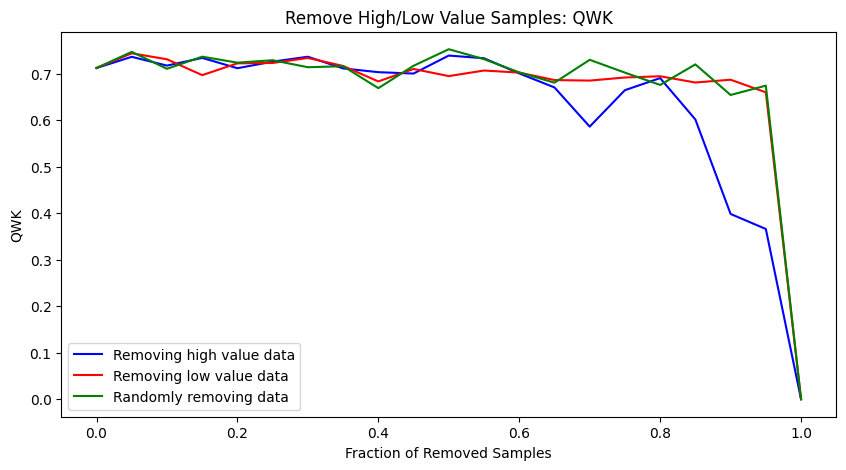

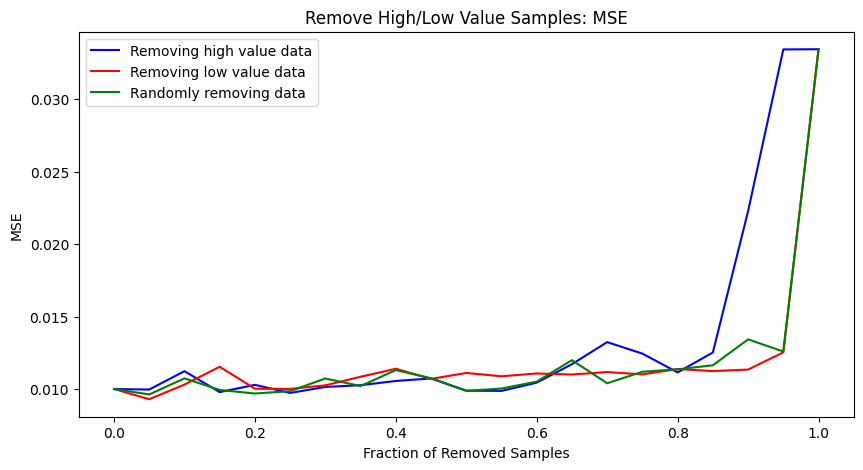

In [8]:
test_prompt_id = 7
# output_path = f'outputs/DVRL_NoiseDetection{test_prompt_id}/'
# output_path = f'outputs/DVRL_NoiseDetection{test_prompt_id}_noMovingAverage_qwk/'
output_path = f'outputs/DVRL_NoiseDetection{test_prompt_id}_noMovingAverage_qwk_seed42/'

seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
configs = Configs()
attribute_name = 'score'

# Load data
data_path = configs.DATA_PATH2 + str(test_prompt_id) + '/fold-0/'
model_name = 'microsoft/deberta-v3-large'

train_features, dev_features, test_features, y_train, y_dev, y_test = create_embedding_features(data_path, test_prompt_id, attribute_name, model_name, device)

# print info
print('================================')
print('X_train: ', train_features.shape)
print('Y_train: ', y_train.shape)
print('Y_train max: ', np.max(y_train))
print('Y_train min: ', np.min(y_train))

print('================================')
print('X_dev: ', dev_features.shape)
print('Y_dev: ', y_dev.shape)
print('Y_dev max: ', np.max(y_dev))
print('Y_dev min: ', np.min(y_dev))

print('================================')
print('X_test: ', test_features.shape)
print('Y_test: ', y_test.shape)
print('Y_test max: ', np.max(y_test))
print('Y_test min: ', np.min(y_test))
print('================================')

# Remove high and low value samples
low_qwks = []
low_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=True)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features, batch_size=256, device=device)
    qwk = calc_qwk(y_dev, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_dev, y_pred)
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)
    low_mse.append(mse)

np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

high_qwks = []
high_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=False)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features, batch_size=256, device=device)
    qwk = calc_qwk(y_dev, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_dev, y_pred)
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)
    high_mse.append(mse)


np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

random_qwks = []
random_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = random_remove_sample(np.load(output_path + 'estimated_data_value.npy'), remove_p=p)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features, batch_size=256, device=device)
    qwk = calc_qwk(y_dev, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_dev, y_pred)
    print(f'QWK: {qwk:.4f}')
    random_qwks.append(qwk)
    random_mse.append(mse)

import matplotlib.pyplot as plt
# plot
p = np.arange(0.0, 1.01, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='blue')
plt.plot(p, low_qwks, label='Removing low value data', color='red')
plt.plot(p, random_qwks, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: QWK')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.savefig(output_path + 'remove_high_low_value_samples_qwk.png')


plt.figure(figsize=(10, 5))
plt.plot(p, high_mse, label='Removing high value data', color='blue')
plt.plot(p, low_mse, label='Removing low value data', color='red')
plt.plot(p, random_mse, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: MSE')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('MSE')
plt.legend()
plt.savefig(output_path + 'remove_high_low_value_samples_mse.png')

In [9]:
data_values = np.load(output_path + 'estimated_data_value.npy')
noise = np.load(output_path + 'noise_indices.npy')

In [10]:
mean = data_values.mean()
std = data_values.std()
noise_mean = data_values[noise].mean()

all_indices = np.arange(len(data_values))
# ノイズでないデータのインデックスを取得
non_noise_indices = np.setdiff1d(all_indices, noise)
# ノイズでないデータのインデックスを使用してデータを選択し、その平均を計算
non_noise_mean = data_values[non_noise_indices].mean()

print(f'All data mean: {mean}')
print(f'All data std: {std}')
print(f'Noise data mean: {noise_mean}')
print(f'Non-noise data mean: {non_noise_mean}')

All data mean: 0.19905315339565277
All data std: 0.041205033659935
Noise data mean: 0.1368599683046341
Non-noise data mean: 0.21456021070480347


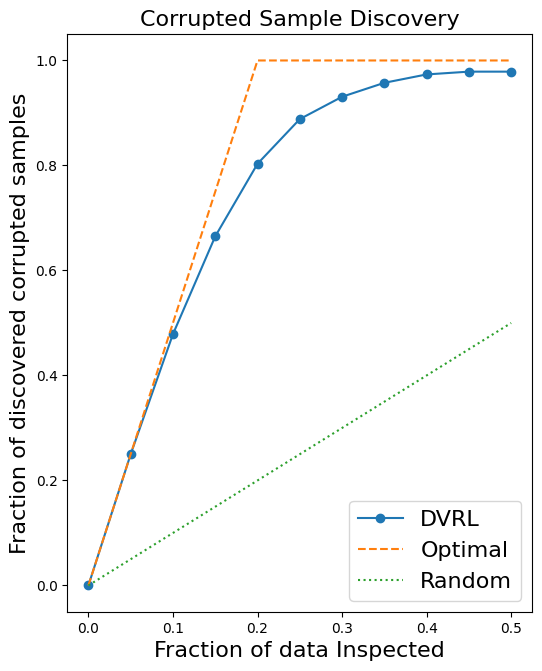

In [11]:
noise_discovery_performance = discover_corrupted_sample(data_values.flatten(), noise, 0.2, output_path, plot=True)

In [12]:
# discover_corrupted_sampleは，データの価値が小さい順にデータを検査するが，以下のdiscover_noise_sampleは，その逆順にデータを検査する

def discover_noise_sample(dve_out, noise_idx, noise_rate, output_path, plot=True, reverse=True):
    data_values = dve_out.flatten()
    noise = noise_idx
    rates = np.arange(0.0, 0.51, 0.05)

    TPRs = []
    for rate in rates:
        count = 0
        if reverse:
            tmp_ids = data_values.flatten().argsort()[::-1][:int(len(data_values) * rate)]
        else:
            tmp_ids = data_values.flatten().argsort()[:int(len(data_values) * rate)]
        for idx in tmp_ids:
            if idx in noise:
                count += 1
        TPR = count / int(len(noise))
        TPRs.append(TPR)

    optimal_plot = np.minimum(1.0 / noise_rate * rates, 1.0)

    random_plot = rates

    if plot:
        plt.figure(figsize=(6, 7.5))
        plt.plot(rates, TPRs, 'o-', label='DVRL')
        plt.plot(rates, optimal_plot, '--', label='Optimal')
        plt.plot(rates, random_plot, ':', label='Random')
        plt.title('Noise Detection Performance')
        plt.xlabel('Fraction of data Inspected')
        plt.ylabel('Fraction of discovered noise samples')
        plt.legend()
        if reverse:
            plt.savefig(output_path + 'noise_detection_performance_by_reverse.png')
        else:
            plt.savefig(output_path + 'noise_detection_performance.png')

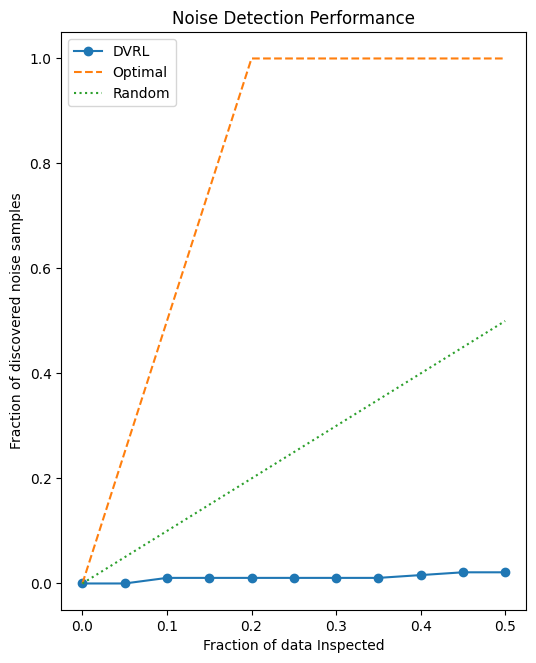

In [13]:
discover_noise_sample(data_values, noise, 0.2, output_path, plot=True, reverse=True)